# WebGL

This is for the CREWES paper. 

We want to simplify the code so there are no redundancies.

Figure out how to get a complicated velocity field in there, like Marmousi.

Use physical values.


We will do the wave equation (2D) on the GPU, using gpgpUtility.




## Math

Let's remember what the wave eqn is:

$$\frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} =  \nabla^2 u.$$

As central differences, we write
$$\frac{1}{c^2} \frac{u(,t-\Delta t) - 2u(,t) + u(,t + \Delta t)}{\Delta t ^2} =  
\frac{u(,x-\Delta x) + u(,y - \Delta y) + u(,x + \Delta x)+ u(,y + \Delta y) - 4u(,)}{\Delta x ^2},$$
where we are assuming $\Delta x = \Delta y$. 

For time-stepping, we re-arrange as
$$u(,t + \Delta t) = 2u(,t) - u(,t-\Delta t) + \frac{c^2 \Delta t^2}{\Delta x^2}
\left[ u(,x-\Delta x) + u(,y - \Delta y) + u(,x + \Delta x)+ u(,y + \Delta y) - 4u(,) \right].$$

When $\Delta x$ and $\Delta y$ are different, we should write as
$$u(,t + \Delta t) = 2u(,t) - u(,t-\Delta t) + 
\frac{c^2 \Delta t^2}{\Delta x^2}
\left[ u(,x-\Delta x) + u(,x + \Delta x)- 2u(,) \right] +
\frac{c^2 \Delta t^2}{\Delta y^2} 
\left[u(,y - \Delta y) + u(,y + \Delta y) - 2u(,) \right].$$

## 

The key is that the waveform $u$ will be stored in a texture buffer. There are three versions, the current waveform ("waveform") the old waveform ("oldwaveform") and the new waveform (which has no name, but is the output of the shader program.)

Basic idea is 
$$ newwaveform = 2*waveform - oldwaveform + Laplacian(waveform).$$

The key bit of WebGL code is this:
```
void main()
{
  float dx;
  float dy;
  float h;
  vec2  dss;
  vec2  dtt;
  vec4  value;
  dx    = xLength/float(xResolution);
  dy    = yLength/float(yResolution);
  dss    = vec2(1.0/float(xResolution), 0.0);
  dtt    = vec2(0.0, 1.0/float(yResolution));
  value = texture2D(waveFunction, vTextureCoord);

  gl_FragColor.r = 2.0*value.r
     - texture2D(oldWaveFunction,vTextureCoord).r
     + (value.g)*dt*dt*( texture2D(waveFunction, vTextureCoord+dss).r
     +     texture2D(waveFunction, vTextureCoord-dss).r 
     -   2.0*value.r)/(dx*dx)"
     +  (value.g)*dt*dt*(texture2D(waveFunction, vTextureCoord+dtt).r
     +     texture2D(waveFunction, vTextureCoord-dtt).r 
     -   2.0*value.r )/(dy*dy); 

  gl_FragColor.g = value.g;  // carry over the speed variable
}
```

## Example 3.

Address the to-do above.


In [37]:
%%writefile myFile1.html
<!DOCTYPE html>
<html><head id="Barebones">
        <meta charset="UTF-8" />
        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
        <script src="GPGPUtility.js"></script>
        <script src="WaveEqn.js"></script>
        <script src="WavePlot.js"></script>
        <title>WebGLwave example for CREWES</title>
        </head>
        <body>
        <div class="content">
            <h1>WebGLwave example for CREWES</h1>


            <figure class="center" id="results">
                <figcaption>
                    You should see a waveform traveling here. 
                </figcaption>
            </figure>
        </div>

        <br class="clear" />
        <script>
            "use strict";

            /** The canvas onto which we render the wave function & potential */
            var canvas;
            var dt;
            var gl;
            var gpgpUtility;
            /** A two element array containing wave functions for t - deltat and t. */
            var initialWaveFunctions;
            var nframes;
            var nsteps;
            var parent;
            var renderer;
            var vel;
            var w;
            var waveengine;
            var waveFunctionData, waveFunctionTexture0, waveFunctionTexture1, waveFunctionTexture2;
            var x0;
            var y0;
            var xLength;
            var xResolution;
            var yLength;
            var yResolution;

            parent = document.getElementById("results")

            xLength = 4000.0; // in meters
            yLength = 4000.0; // in meters
            vel = 1000.0; // velocity in m/s
            x0 = .25*xLength; // location and width of initial Gaussian
            y0 = .75*yLength;
            w = 0.05*xLength; // width of the initial Gaussian

            // number of sample points (x-dir y-dir)
            xResolution = 1000; 
            yResolution = 1000; 
            // sample interval in time
            dt = .001; // seconds
            // Number of frames to compute and animate
            nframes = 600;
            // Number of delta t timesteps per frams
            nsteps = 5;

            gpgpUtility = new vizit.utility.GPGPUtility(xResolution, yResolution, {premultipliedAlpha: false});
            gpgpUtility.setProblemSize(xResolution, yResolution);

            canvas = gpgpUtility.getCanvas();
            canvas.style.height = yResolution + "px";
            parent.insertBefore(canvas, parent.firstChild);

            function gaussWaveform(waveform,xRez,yRez,xLen,yLen) {
                for (var j = 0; j < yRez; ++j) {
                    for (var i = 0; i < xRez; ++i) {
                        var x = xLen*(i/xRez) - x0;
                        var y = yLen*(j/yRez) - y0;
                        waveform[4*(i + j*xRez)] = 
                            10.0*Math.exp(-(x*x + y*y)/(w*w))*Math.cos(x/50 - y/50);
                        waveform[4*(i + j*xRez) + 1] = 
                            (j > yRez/2) ? 1.0 : 0.1;
                    }
                }
                return waveform;
            }
            // we stuff velocity^2 info into the green channel;
            function velField(waveform,xRez,yRez) {
                for (var j = 0; j < yRez; ++j) {
                    for (var i = 0; i < xRez; ++i) {
                        waveform[4*(i + j*xRez) + 1] = 
                            (j > yRez/2) ? vel*vel : .25*vel*vel;
                    }
                }
                return waveform;
            }

            /**
             * Run the simulation for n time steps, then show the results.
             */
            function nextFrame() {
                for (var i = 0; i < nsteps; ++i) {
                    waveengine.timestep();
                }

                renderer.show(waveengine.getRenderedTexture());

                if (nframes--) {
                    requestAnimationFrame(nextFrame);
                }
            }

            waveFunctionData = new Float32Array(4 * xResolution * yResolution);
            waveFunctionData = gaussWaveform(waveFunctionData,xResolution,yResolution,xLength,yLength);
            waveFunctionData = velField(waveFunctionData,xResolution,yResolution);

            waveFunctionTexture0 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionData);
            waveFunctionTexture1 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionData);
            waveFunctionTexture2 = gpgpUtility.makeTexture(WebGLRenderingContext.FLOAT, waveFunctionData);


            waveengine = new WaveEngine(gpgpUtility, xResolution, yResolution, xLength, yLength, dt);
            renderer = new WaveResults(gpgpUtility, parent, xResolution, yResolution);

            waveengine.setInitialTextures(waveFunctionTexture0, waveFunctionTexture1, waveFunctionTexture2);

            renderer.show(waveengine.getRenderedTexture());

/*****************
 *  Assorted timing information. Don't need to run this.
    var startGPU = window.performance.now();
    var result = waveengine.timestep();
    var endGPU = window.performance.now();
    var gpuTime = endGPU - startGPU;
    console.log(`GPU - one step: ${gpuTime}ms`);
    // do it again, in a loop
    startGPU = window.performance.now();
         for (var i = 0; i < 100; ++i) {
             result = waveengine.timestep();
        }
    endGPU = window.performance.now();
    gpuTime = endGPU - startGPU;
    console.log(`GPU - 100 steps: ${gpuTime}ms`);
    console.log(`endGPU: ${endGPU}ms`);
    console.log(`startGPU: ${startGPU}ms`);
****************/

            requestAnimationFrame(nextFrame);
    </script>
</html>

Overwriting myFile1.html


In [20]:
%%html
<iframe src='myFile1.html' width=1000 height=1000>

I don't understand the timings that I am getting. So let's plot a few things.

In [23]:
Loopsize = [10,10,20,20,30,30,40,40,50,50]
WinTime = [1.137,1.056,3.729,3.772,6.856,6.881,9.729,9.545,12.468,12.536]
RealTime = [3.56,3.55,6.60,6.42,9.52,9.50,12.62,12.28,15.35,15.29]

In [2]:
from matplotlib.pyplot import *

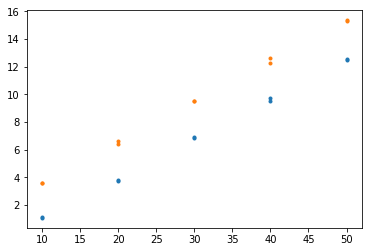

In [24]:
plot(Loopsize,WinTime,'.', Loopsize,RealTime,'.')

In [5]:
import numpy as np
import scipy.optimize as optimization

In [6]:
def func(x, a, b):
    return a + b*x 

In [ ]:
xdata = np.array(Loopsize)
ydata = np.array(WinTime)
ab0    = np.array([0.0, 0.0])
print(optimization.curve_fit(func, xdata, ydata, ab0))

In [ ]:
xdata = np.array(Loopsize)
ydata = np.array(RealTime)
ab0    = np.array([0.0, 0.0])
print(optimization.curve_fit(func, xdata, ydata, ab0))

Slope is about .29 seconds/outerloop. 

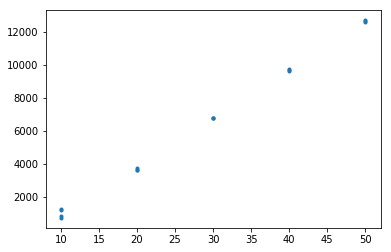

In [11]:
Loopsize = [10,10,10,10,20,20,20,30,30,30,40,40,40,50,50,50]
WinTime = [737,863,1248,1188,3618,3758,3645,6817,6792,6801,9669,9616,9755,12610,12707,12685]
plot(Loopsize,WinTime,'.');

In [12]:
xdata = np.array(Loopsize)
ydata = np.array(WinTime)
ab0    = np.array([0.0, 0.0])
print(optimization.curve_fit(func, xdata, ydata, ab0))

(array([-2006.47036848,   292.63592588]), array([[ 7.49089469e+03, -2.07579009e+02],
       [-2.07579009e+02,  7.22013939e+00]]))


In [18]:
xdata = np.array([5,10,50])
ydata = np.array([.0124,.820,12.686])
ab0    = np.array([0.0, 0.0])
print(optimization.curve_fit(func, xdata, ydata, ab0))

(array([-1.72074795,  0.28739452]), array([[ 0.14391535, -0.00356362],
       [-0.00356362,  0.00016447]]))


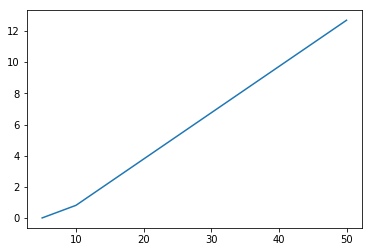

In [17]:
plot([5,10,50],[.0124,.820,12.686])

In [19]:
19/.0124


1532.258064516129

In [20]:
38/.820


46.34146341463415

In [21]:
191.1/12.686

15.063849913290241

In [22]:
3.82/.287

13.310104529616725

## Nvidia card

I have an nvidia card in a PC in the next room. 50,000 loops takes 3.662 seconds. That's 4 times faster than on my Power Mac. Wow.

In [25]:
3.662/50000

7.324e-05

In [26]:
3.82/Out[25]

52157.29109776079